# Introduction

Suite √† notre analyse pr√©c√©dente bas√©e sur le clustering K-means (3_ACP_K-means_Amazing), bien que certains groupes d'utilisateurs aient pu √™tre identifi√©s, les r√©sultats obtenus ne sont pas enti√®rement satisfaisants. En effet, la segmentation bas√©e sur les variables comportementales telles que le nombre de sessions, la valeur totale des achats, et le score de fid√©lit√© a r√©v√©l√© des diff√©rences significatives entre certains clusters. Cependant, ces clusters ne semblent pas capturer de mani√®re optimale les nuances dans le comportement des utilisateurs, notamment en ce qui concerne leur engagement et leur contribution √† la performance globale.

Ainsi, pour mieux comprendre nos utilisateurs et proposer des actions marketing plus pertinentes, nous devons envisager une autre approche plus adapt√©e √† la dynamique de la client√®le d'Amazing. La m√©thode de Segmentation RFM (R√©cence, Fr√©quence, Valeur Mon√©taire), largement reconnue dans les strat√©gies de fid√©lisation et de gestion de la relation client, s'av√®re √™tre une alternative particuli√®rement int√©ressante.

### √âtapes pour appliquer la m√©thode RFM :
1. **R√©cence (Recency)** : Nombre de jours depuis la derni√®re interaction ou achat.
2. **Fr√©quence (Frequency)** : Nombre de fois qu'un utilisateur a interagi ou achet√©.
3. **Valeur Mon√©taire (Monetary Value)** : Montant total d√©pens√© par l'utilisateur.

### Calcul des Scores RFM :
1. **R√©cence** : Utiliser la colonne `days_since_last_purchase`.
2. **Fr√©quence** : Utiliser les colonnes de fr√©quence des interactions (`number_of_sessions_2m`, `number_of_sessions_5m`, etc.).
3. **Valeur Mon√©taire** : Utiliser `total_purchase_value`.


En cons√©quence, nous allons explorer cette m√©thode pour obtenir une segmentation plus pertinente et align√©e sur nos objectifs commerciaux.


In [4]:
# Importation des biblioth√®ques n√©cessaires 

import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
# import requests
# import io
# from urllib.parse import urljoin

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree

In [2]:
# # URL directe vers le fichier Parquet sur GitHub
# base_url = "https://github.com/EricIrjam/e-amazing/raw/main/data/user_stats_df_output.parquet/"


In [3]:
# # Fonction pour r√©cup√©rer et lire tous les fichiers .parquet dans le r√©pertoire
# def read_parquet_files(base_url):
#     # Les fichiers que nous devons r√©cup√©rer
#     file_names = [
#         f"part-0000{i}-9b319896-debc-49c4-b0a7-fbbd59863d51-c000.snappy.parquet" for i in range(5)
#     ]

#     # Lire et combiner tous les fichiers Parquet en un seul DataFrame
#     tables = []
#     for file_name in file_names:
#         file_url = urljoin(base_url, file_name)
#         response = requests.get(file_url)
#         response.raise_for_status()

#         # Lire le fichier Parquet
#         table = pq.read_table(io.BytesIO(response.content))
#         tables.append(table)

#     # Combiner toutes les tables en une seule
#     combined_table = pa.concat_tables(tables)
#     return combined_table.to_pandas()

In [5]:
# Charger les donn√©es √† partir du fichier Parquet
df = pd.read_parquet('/app/data/full_df_output.parquet')

# Mise en ≈ìuvre de la segmentation RFM et √©valuation des clusters


In [6]:

# Calcul des scores RFM
# Recency : on utilise la colonne 'days_since_last_purchase' (moins c'est √©lev√©, mieux c'est)
df['R_Score'] = pd.qcut(df['days_since_last_purchase'], q=4, labels=[4, 3, 2, 1])

# Frequency : on utilise les sessions des 7 derniers mois (plus c'est √©lev√©, mieux c'est)
df['F_Score'] = pd.qcut(df['number_of_sessions_7m'], q=4, labels=[1, 2, 3, 4])

# Monetary Value : on utilise la colonne 'total_purchase_value' (plus c'est √©lev√©, mieux c'est)
df['M_Score'] = pd.qcut(df['total_purchase_value'], q=4, labels=[1, 2, 3, 4])

# Pr√©paration des donn√©es pour le clustering
X = df[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Calcul de l'indice de silhouette pour diff√©rents nombres de clusters
silhouette_scores = []
range_n_clusters = range(3, 15)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)



# Visualisation de l'√©volution de l'indice de silhouette en fonction du nombre de clusters

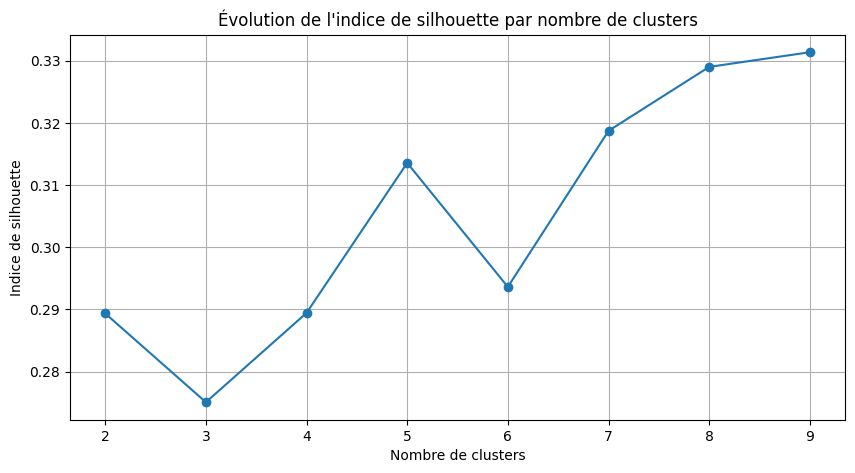

In [6]:
# Graphique de l'√©volution de l'indice de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("√âvolution de l'indice de silhouette par nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")
plt.grid(True)
plt.show()



1. **Indice de silhouette** :
   - Un indice de silhouette proche de 1 indique que les clusters sont bien s√©par√©s et denses.
   - Un indice proche de 0 signifie que les clusters se chevauchent ou ne sont pas clairement distincts.
   - Des valeurs n√©gatives (bien qu'il n'y en ait pas ici) indiquent que des points sont probablement affect√©s au mauvais cluster.

2. **Nombre de clusters optimal** :
   Nous observons un pic de l'indice de silhouette autour de 5 clusters, ce qui nous fait penser que 5 clusters pourraient √™tre un bon choix pour une segmentation optimale selon cet indicateur. Cependant, Si nous souhaitons aller plus loin dans la granularit√© de l'analyse, tester avec 8 ou 9 clusters pourrait nous offrir une segmentation plus d√©taill√©e des clients, en prenant en compte des crit√®res comme les gammes de produits ou la fr√©quence des achats.



In [16]:
# Clustering avec le nombre optimal de clusters trouv√© (exemple : 6 clusters)
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Visualisation 3D du clustering RFM avec le nombre optimal de clusters

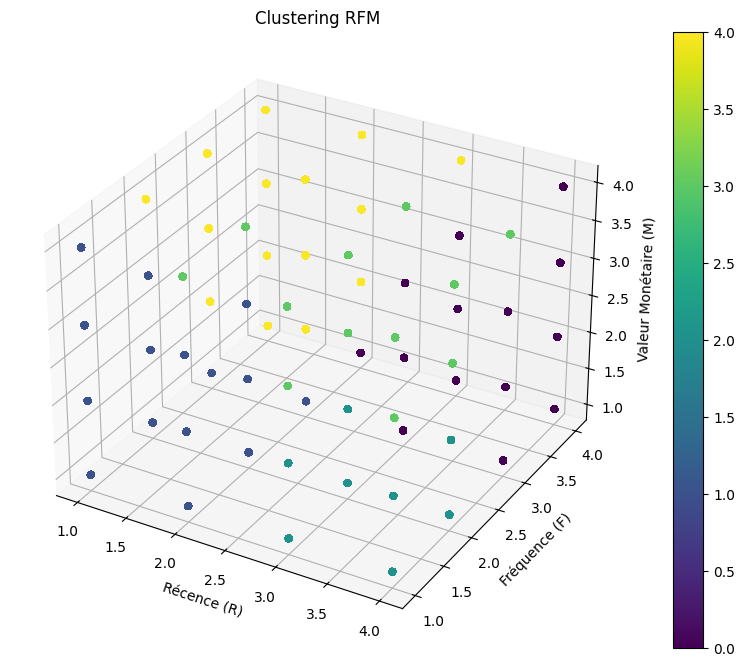

In [17]:


# Graphique 3D du clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['R_Score'], df['F_Score'], df['M_Score'], c=df['cluster'], cmap='viridis')

# Titres et labels
ax.set_title('Clustering RFM')
ax.set_xlabel('R√©cence (R)')
ax.set_ylabel('Fr√©quence (F)')
ax.set_zlabel('Valeur Mon√©taire (M)')
plt.colorbar(scatter)
plt.show()


#  S√©paration des donn√©es et de la cible pour le mod√®le de classification 


In [18]:
X = df[['R_Score', 'F_Score', 'M_Score']]  # Caract√©ristiques RFM
y = df['cluster']  # Cible : cluster attribu√©

In [19]:
# Division des donn√©es en ensembles d'entra√Ænement et de test
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Cr√©ation et entra√Ænement du mod√®le Decision Tree

In [20]:

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

#  Pr√©diction sur l'ensemble de test 

In [21]:

predictions = tree.predict(data_test)

# √âvaluation du mod√®le (accuracy) 

In [22]:

accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


# Afficher le rapport de classification et la matrice de confusion



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3166
           1       0.91      0.97      0.94      3868
           2       1.00      1.00      1.00      2944
           3       0.72      1.00      0.84      2719
           4       1.00      0.84      0.91      4276

    accuracy                           0.92     16973
   macro avg       0.93      0.92      0.92     16973
weighted avg       0.94      0.92      0.92     16973


Confusion Matrix:


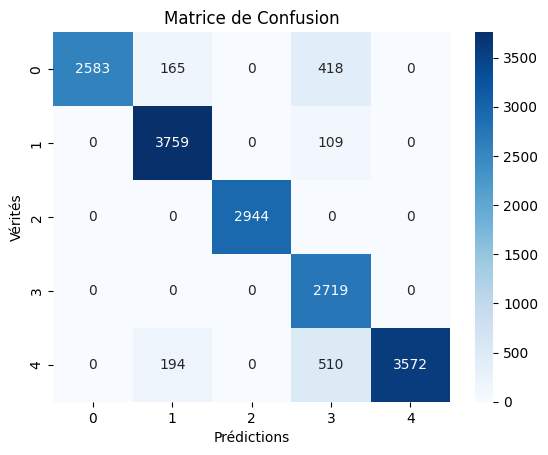

In [23]:
print("\nClassification Report:")
print(classification_report(target_test, predictions))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(target_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Pr√©dictions')
plt.ylabel('V√©rit√©s')
plt.show()

La matrice de confusion, nous pouvons tirer quelques conclusions int√©ressantes sur la performance de notre mod√®le de classification. 

Tout d'abord, nous remarquons que pour la classe 0, bien que le mod√®le ait correctement pr√©dit 2583 instances, il a encore 418 erreurs o√π les pr√©dictions sont all√©es vers la classe 3. 
Cela signifie que nous avons un certain chevauchement entre ces classes. Pour la classe 1, le mod√®le est assez performant avec seulement 109 erreurs, ce qui se refl√®te bien dans le score de rappel de 0.97 dans notre rapport de classification.

Pour la classe 2, les r√©sultats sont presque parfaits avec aucune confusion, ce qui explique la pr√©cision et le rappel de 1.00 pour cette classe. Cependant, pour la classe 3, m√™me si le rappel est √©lev√© (1.00), la pr√©cision est plus faible (0.72), ce qui indique que de nombreuses instances de la classe 4 sont confondues avec la classe 3, comme nous pouvons le voir avec les 510 pr√©dictions incorrectes.

Enfin, pour la classe 4, bien que la pr√©cision soit √©lev√©e (1.00), le mod√®le a encore du mal √† diff√©rencier cette classe des autres, notamment avec les 194 instances mal class√©es comme 1 et 510 instances mal class√©es comme 3.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

Globalement, avec une pr√©cision pond√©r√©e de **0.94** et une exactitude de **0.92**, nous pouvons √™tre satisfaits des performances du mod√®le, mais il y a encore des am√©liorations √† faire, notamment dans la distinction entre les classes 3 et 4.

</div> 

# Visualisation de l'arbre de d√©cision


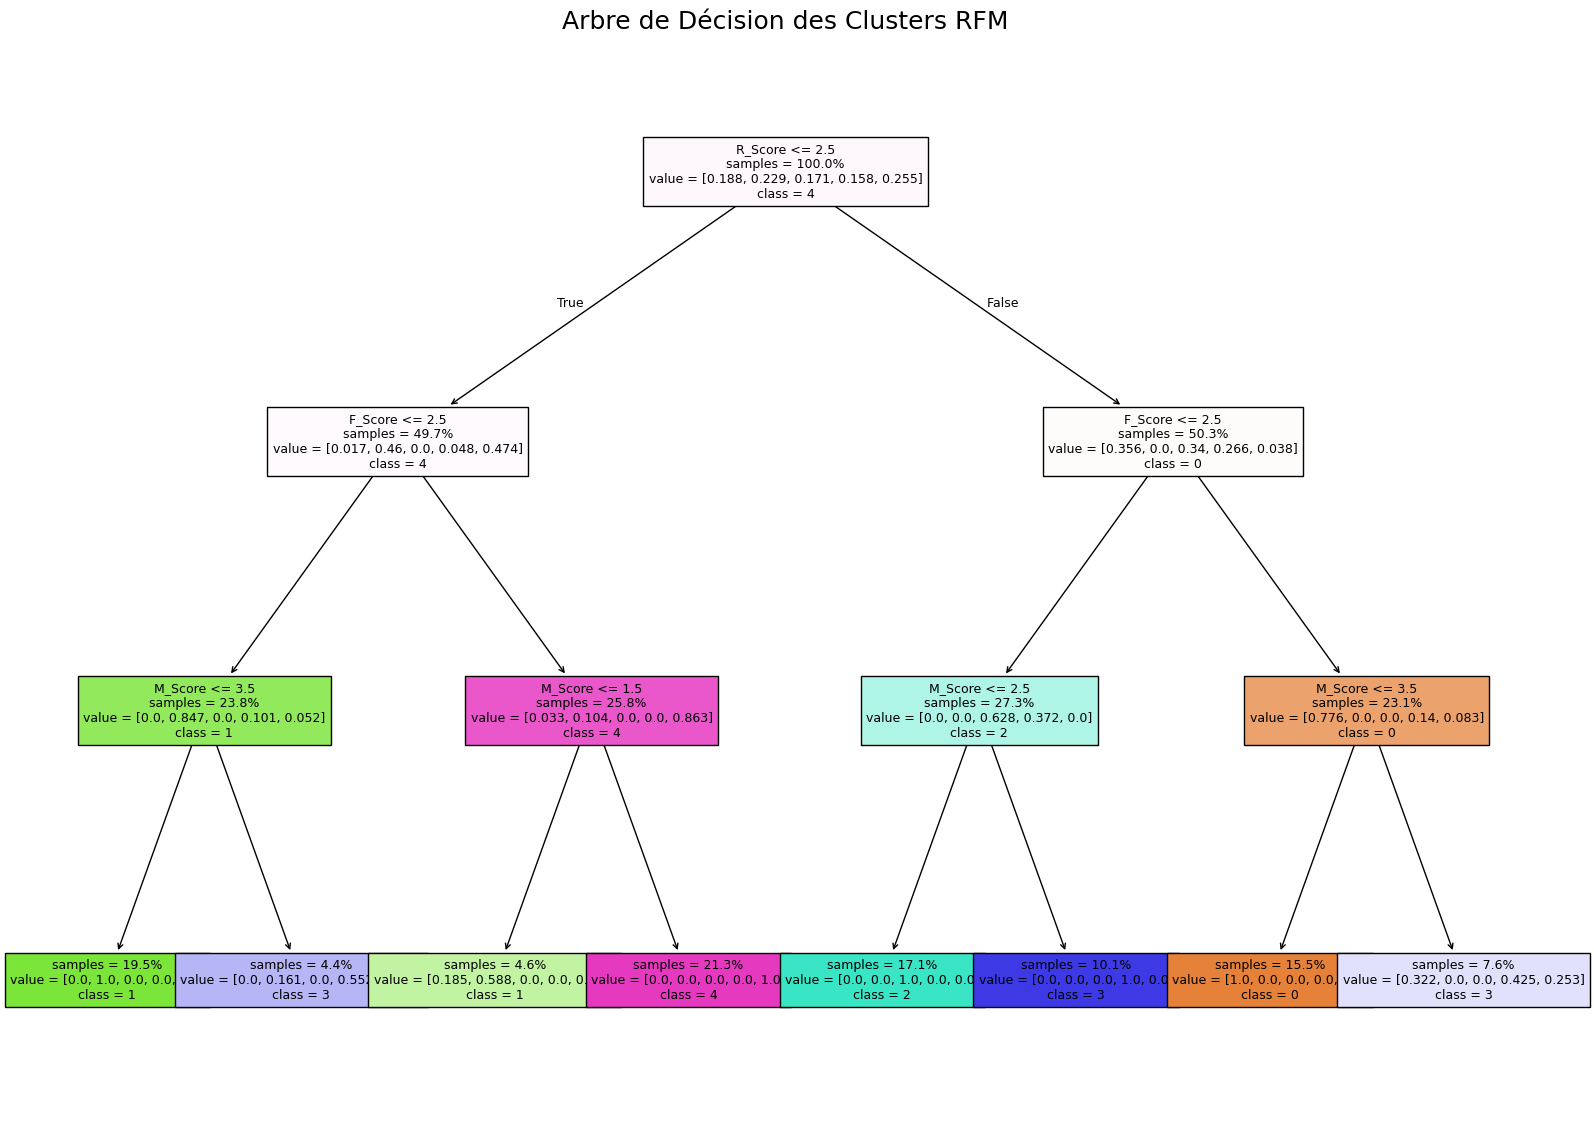

In [24]:
# Entra√Ænement de l'arbre de d√©cision (comme dans la partie pr√©c√©dente du code)
# Nommons l'arbre de d√©cision "clf" pour √©viter le conflit avec le module "tree"
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(data_train, target_train)

# D√©finir les noms des features et des classes pour l'affichage de l'arbre
feature_names = ['R_Score', 'F_Score', 'M_Score']
class_names = [str(cls) for cls in clf.classes_]  # Utiliser l'objet "clf" qui a √©t√© form√©

# Visualisation de l'arbre de d√©cision avec une taille de figure ajust√©e
_, ax = plt.subplots(figsize=(20, 14), dpi=100)  # Augmentation de la taille et de la r√©solution de la figure
plot_tree(
    clf,  # Utilisation du mod√®le "clf" ici
    feature_names=feature_names,
    class_names=class_names,
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=9, 
    proportion=True
)

plt.title('Arbre de D√©cision des Clusters RFM', fontsize=18)
plt.show()



En regardant cet arbre de d√©cision, nous pouvons associer diff√©rents groupes de clients √† des animaux pour mieux visualiser leurs comportements :

- Tout d'abord, pour les clients avec un **R_Score ‚â§ 2.5**, ce qui signifie qu‚Äôils ne sont pas tr√®s r√©cents, nous pouvons les comparer √† des **hiboux ü¶â**. Ces clients sont plus discrets, moins actifs, et se trouvent majoritairement dans la classe 4. Certains, comme ceux avec un **F_Score ‚â§ 2.5** et un **M_Score ‚â§ 3.5**, peuvent √™tre des **ours en hibernation üêª**. Ils reviennent de temps en temps, mais ne d√©pensent pas √©norm√©ment.

- Ensuite, pour les clients avec un **F_Score √©lev√©** mais un faible **M_Score** (‚â§ 1.5), nous avons des **√©cureuils üêøÔ∏è**. Ces clients reviennent fr√©quemment, mais leurs achats sont modestes, un peu comme un √©cureuil qui accumule de petites quantit√©s.

- Pour ceux avec un **R_Score √©lev√©** (plus r√©cents) et un **M_Score > 3.5**, nous sommes en pr√©sence de **lions ü¶Å**. Ces clients sont puissants et font des achats importants, bien qu'ils soient plus r√©cents. Ils dominent la sc√®ne dans les classes 0 et 2. Ce sont les clients √† chouchouter, car ils ont un potentiel de valeur √©lev√©.

- Enfin, les clients dans les classes 3 et 2, avec un **F_Score ‚â§ 2.5**, peuvent √™tre compar√©s √† des **renards ü¶ä**. Ils ne reviennent pas tr√®s souvent, mais lorsqu'ils le font, ils d√©pensent un montant consid√©rable, ce qui en fait des cibles int√©ressantes pour nos strat√©gies marketing.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

En somme, cet arbre nous permet d'identifier et de comprendre la diversit√© des comportements de clients en fonction de leur r√©cence, fr√©quence et montant. Les **hiboux ü¶â** et **ours en hibernation üêª** n√©cessitent peut-√™tre des efforts de r√©activation, tandis que les **lions ü¶Å** et **renards ü¶ä** sont des clients √† haute valeur que nous devons fid√©liser avec soin.

</div> 